# Transfer Learning with MobileNetV2

In this notebook, I'm going to use transfer learning and fine-tuning on MobileNetV2 to build an Alpaca/Not Alpaca classifier!

MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

In [77]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Creating the Dataset from a directory containing images

In [78]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


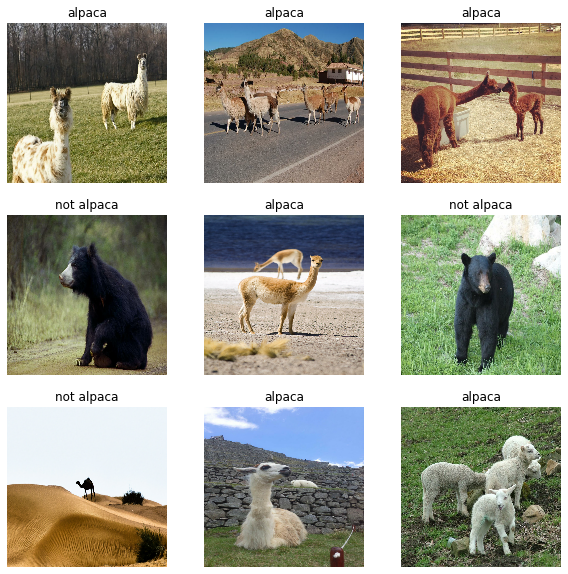

In [79]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Preprocess and Augment Training Data

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk.

In [80]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [81]:
def data_augmenter():

    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

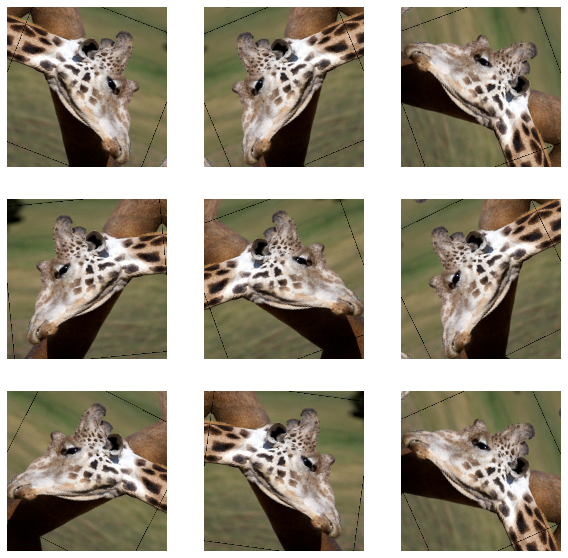

In [83]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

### Importing the preprocessing method of our Pretrained Model

In [84]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Using MobileNetV2 for Transfer Learning

In [86]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [87]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Testing MobileNetV2 over our first batch

In [91]:
base_model.trainable = False
image_batch, label_batch = next(iter(train_dataset))
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n02489166', 'proboscis_monkey', 0.10329965),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883611)],
 [('n02125311', 'cougar', 0.1654676), ('n02389026', 'sorrel', 0.10764261)],
 [('n02437312', 'Arabian_camel', 0.2923283),
  ('n02437616', 'llama', 0.27713484)],
 [('n03944341', 'pinwheel', 0.31154886), ('n03047690', 'clog', 0.052500293)],
 [('n02454379', 'armadillo', 0.73107153),
  ('n01990800', 'isopod', 0.038719974)],
 [('n02437312', 'Arabian_camel', 0.25663644),
  ('n02422106', 'hartebeest', 0.12122728)],
 [('n02437616', 'llama', 0.6612557),
  ('n02090721', 'Irish_wolfhound', 0.23782855)],
 [('n02133161', 'American_black_bear', 0.82735676),
  ('n02134418', 'sloth_bear', 0.02925945)],
 [('n01518878', 'ostrich', 0.9267562),
  ('n02002724', 'black_stork', 0.0017766367)],
 [('n01518878', 'ostrich', 0.94954586),
  ('n02018795', 'bustard', 0.0028661634)],
 [('n02437616', 'llama', 0.8699833), ('n02412080', 'ram', 0.076757126)],
 [('n02415577', 'bighorn', 0.2429446), ('n02412080', 'ram', 

There's a whole lot of labels here but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas.

### Transfer Learning

In [92]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):

    input_shape = image_shape + (3,)

    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    
    x = preprocess_input(x)
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x)

    x = tfl.Dropout(0.2)(x)
        
    outputs = tfl.Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [95]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [96]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 890ms/step - loss: 0.7509 - accuracy: 0.5458 - val_loss: 0.5383 - val_accuracy: 0.6000
Epoch 2/5
9/9 [==============================] - 7s 812ms/step - loss: 0.6028 - accuracy: 0.6527 - val_loss: 0.4711 - val_accuracy: 0.6308
Epoch 3/5
9/9 [==============================] - 7s 812ms/step - loss: 0.4711 - accuracy: 0.7405 - val_loss: 0.3893 - val_accuracy: 0.7231
Epoch 4/5
9/9 [==============================] - 7s 799ms/step - loss: 0.4921 - accuracy: 0.7405 - val_loss: 0.4266 - val_accuracy: 0.6462
Epoch 5/5
9/9 [==============================] - 7s 781ms/step - loss: 0.3972 - accuracy: 0.8015 - val_loss: 0.3022 - val_accuracy: 0.8000


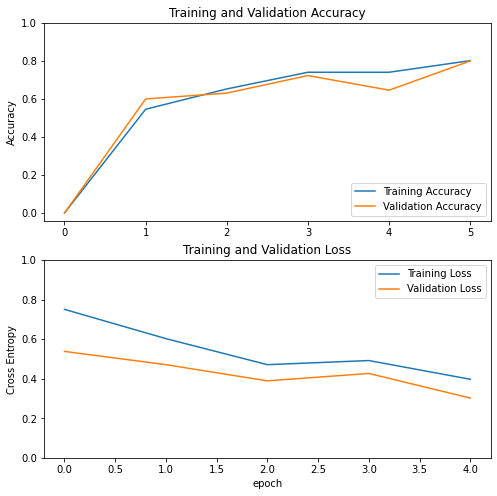

In [97]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning the Model

I'm going to fine-tune the model by re-running the optimizer in the last layers to improve accuracy.
I'm going to use a smaller learning rate because I want smaller steps now.

In [99]:
base_model = model2.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(lr = 0.1 * base_learning_rate )

metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [101]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.5888 - accuracy: 0.7290 - val_loss: 0.2839 - val_accuracy: 0.8462
Epoch 6/10
9/9 [==============================] - 9s 987ms/step - loss: 0.3562 - accuracy: 0.8092 - val_loss: 0.2059 - val_accuracy: 0.9692
Epoch 7/10
9/9 [==============================] - 9s 959ms/step - loss: 0.3316 - accuracy: 0.8511 - val_loss: 0.1991 - val_accuracy: 0.8923
Epoch 8/10
9/9 [==============================] - 9s 956ms/step - loss: 0.2355 - accuracy: 0.9046 - val_loss: 0.1271 - val_accuracy: 0.9385
Epoch 9/10
9/9 [==============================] - 9s 989ms/step - loss: 0.1512 - accuracy: 0.9466 - val_loss: 0.0711 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 9s 955ms/step - loss: 0.1630 - accuracy: 0.9427 - val_loss: 0.0562 - val_accuracy: 0.9846


In [102]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

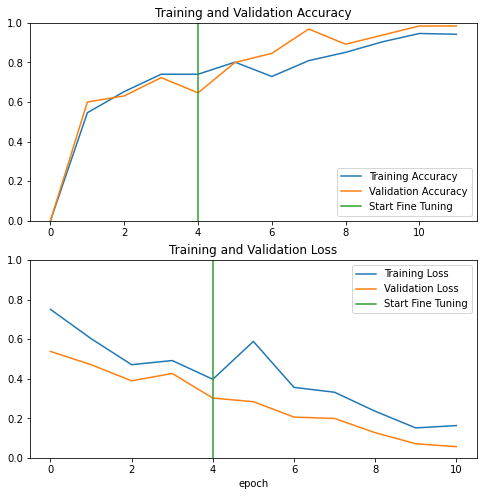

In [103]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()